In [39]:
import numpy as np
from scipy.spatial import distance
import scipy.integrate as integrate
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
from multiprocessing import Pool
from functools import partial
from datetime import datetime
import ast
from os import walk, path, mkdir

In [2]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [3]:
class Run:
    
    def __init__(self, f=0, sigma=0.2, eps=0.005, x0=[0.1,0.1], rng=np.random):
        self.rng    = rng
        
        self.f      = f
        self.sigma  = sigma
        self.A      = np.array([[(1-self.f)**-1, 0],[0, 1-self.f]])
        self.n_min  = 1e-6
        self.n_init = 1e-6
        
        self.mu     = 2e-7*100
        self.eps    = eps
        
        self.grid_fineness = 5
        
        self.tick      = 0
        self.tau       = 100
        self.points    = set()
        self.history   = {}
        
        self.n = np.array([self.n_init])
        self.x = np.array([x0])
        
        self.generate_b_vector_and_a_matrix()
    
    def generate_nearby_point(self, x):
        random_point = (np.random.random(x.shape) * 2 - 1) * self.eps
        
        if np.linalg.norm(random_point) > self.eps:
            return self.generate_nearby_point(x)
        
        return x + random_point.round(self.grid_fineness)
    
    def generate_b_vector_and_a_matrix(self):
        self.b = 1 - np.einsum("ik, kl, il->i", self.x, self.A, self.x)
        
        dist2  = distance.squareform(distance.pdist(self.x, "sqeuclidean"))
        self.a = np.exp(-dist2 / (2 * self.sigma**2))
    
    def get_derivative(self, n, t):
        I = np.dot(self.a, n)
        return (self.b - I) * n
    
    def mutate(self):
        new_species = False
        
        chances = self.mu * self.b * self.n * 100
        randoms = self.rng.random(chances.shape)
        
        mutation_indices = np.where(randoms < chances)[0]
        
        for ind in mutation_indices:
            self.n[ind] -= self.n_init
            new_pos = self.generate_nearby_point(self.x[ind])
            self.x = np.vstack((self.x, new_pos))#check
            self.n = np.hstack((self.n, self.n_init))#check
            
            new_species = True
            self.points.add(tuple(new_pos))
        
        if new_species:
            self.generate_b_vector_and_a_matrix()
        
        return new_species
    
    def die_out(self):
        keep_indices = self.n >= self.n_min
        
        if not np.all(keep_indices):
            self.n = self.n[keep_indices]
            self.x = self.x[keep_indices]
            
            self.generate_b_vector_and_a_matrix()
            return True
        
        return False
    
    def log_state(self):
        self.history[self.tick] = np.copy(self.x)
    
    def step(self):
        result_vector = integrate.odeint(self.get_derivative, self.n, [self.tick, self.tick+self.tau])
        self.n = result_vector[-1]
        
        changed = False
        
        changed |= self.die_out()
        changed |= self.mutate()
        
        if changed:
            self.log_state()
        
        self.tick += 1
    
    def save(self, filename):
        with open(filename, "w") as file:
            for time, array in self.history.items():
                file.write(str(time))
                file.write("\n")
                file.write(str(array.tolist()))
                file.write("\n")

In [17]:
%%time
r = Run()
for _ in range(100000):
    r.step()

print(r.x)
print(r.n)

[[ 0.02169  0.13284]
 [ 0.05714 -0.03434]
 [ 0.06164 -0.03537]]
[0.56246096 0.36326669 0.24302687]
CPU times: user 25.8 s, sys: 35.8 ms, total: 25.8 s
Wall time: 25.8 s


In [24]:
cmap = plt.get_cmap("viridis")

def simple_plot(run, colorful=False):
    plt.figure()
    
    
    if colorful:
        max_time = max(r.history.keys())
        
        for time, x in r.history.items():
            plt.scatter(x[:,0], x[:,1], color=cmap(time/max_time))
    else:
        points = np.array(list(run.points))
        plt.scatter(points[:, 0], points[:, 1]);

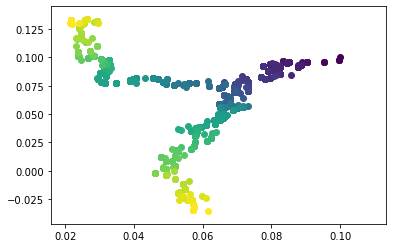

In [26]:
simple_plot(r, colorful=True)

# Field visualization

#### Generation of field

In [32]:
field = np.zeros((100,100))
f   = 0.01
A   = np.array([[(1-f)**-1, 0],[0, 1-f]])

for i, x in enumerate(np.linspace(-1, 1, 100)):
    for j, y in enumerate(np.linspace(-1, 1, 100)):
        X = np.array([x,y])
        field[i, j] = 1 - np.dot(X, np.dot(A, X))

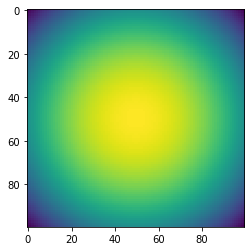

In [33]:
plt.figure(figsize=(4,4))
plt.imshow(asd);

In [37]:
#uncomment for interactive plots
#%matplotlib notebook

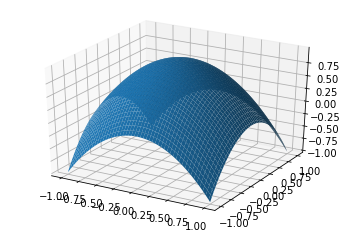

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

grids = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
ax.plot_surface(grids[0], grids[1], field)

# Queued runs

In [28]:
def single_run(i, seed, time_interval=1000000, filename="untitled", **params):
    rng = np.random.default_rng(seed)
    
    r = Run(rng=rng, **params)
    for _ in range(time_interval):
        r.step()
    r.save(filename + "_%i" % i)

seed_seq = np.random.SeedSequence(np.random.randint(0, 2**32))

def make_runs(n_times=10, **params):
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time + ": Running %s" % params["filename"])
    
    p = Pool(8)
    func = partial(single_run, **params)
    p.starmap(func, tuple(zip(range(n_times), seed_seq.spawn(n_times))))
    
    print("Done")

In [27]:
for sigma in [1.0, 0.7, 0.5, 0.2]:
    make_runs(sigma=sigma, filename="sigma_%.1f" % sigma, n_times = 16)

make_runs(sigma=0.5, x0=[0, 0], eps=0.0025, filename="eps_0025", n_times = 32)
make_runs(sigma=0.5, x0=[0, 0], eps=0.005 , filename="eps_005", n_times = 32)

make_runs(sigma=0.5, x0=[0, 0], eps=0.005 , filename="long", n_times = 8, time_interval=5000000)
make_runs(f=0.2, sigma=0.5, x0=[0, 0], eps=0.01 , filename="long_asym", n_times = 8, time_interval=5000000)

01:47:45: Running sigma_1.0


Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-7:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.

KeyboardInterrupt: 

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(

# Saved history analysis

In [4]:
def read_history_map(filename):
    hist_map = {}
    
    with open(filename, "r") as file:
        
        last_time = -1
        
        while True:
            time  = file.readline()
            vects = file.readline()
            
            if not vects:
                break
            
            time  = int(time.strip())
            vects = ast.literal_eval(vects.strip())
            
            for x in vects:
                x = tuple(x)
                if x not in hist_map:
                    hist_map[x] = [[time, last_time]]
                
                if hist_map[x][-1][1] == last_time:
                    hist_map[x][-1][1] = time
                else:
                    hist_map[x].append([time, time])
            
            last_time = time
        
        return hist_map

In [5]:
hist_map = read_history_map("data/sigma_0.2_0")

In [6]:
def plot_time_vs_axis_colorful(hist_map, axis, ax, color=None):
    for x, Ts in hist_map.items():
        for t1, t2 in Ts:
            if axis == 0:
                ax.plot([x[0], x[0]], [t1/1e6, t2/1e6], color=color)
            elif axis == 1:
                ax.plot([t1/1e6, t2/1e6], [x[0], x[0]], color=color)
    
    if axis == 0:
        ax.set_xlabel("x")
        ax.set_ylabel("t [$10^6 \\tau$]")
    elif axis == 1:
        ax.set_xlabel("t [$10^6 \\tau$]")
        ax.set_ylabel("y", labelpad=-5)

def plot_time_vs_axis_fast(hist_map, axis, ax, color="black"):
    X = np.repeat(np.array(list(hist_map.keys()))[:, axis], 3)
    T = np.ravel([x[-1] + [np.nan] for x in hist_map.values()]) / 1e6
    
    if axis == 0:
        ax.plot(X, T, color=color)
        
        ax.set_xlabel("x")
        ax.set_ylabel("t [$10^6 \\tau$]")
    elif axis == 1:
        ax.plot(T, X, color=color)
        
        ax.set_xlabel("t [$10^6 \\tau$]")
        ax.set_ylabel("y", labelpad=-5)

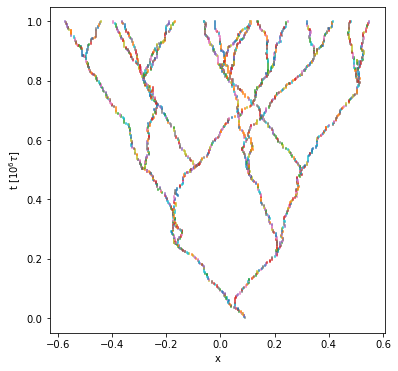

In [7]:
plt.figure(figsize=(6,6))

plot_time_vs_axis_colorful(hist_map, 0, ax=plt.gca())

In [8]:
def plot_2d_colorful(hist_map, ax, color="black", use_labels=True):
    X  = np.array(list(hist_map.keys()))
    T2 = np.ravel([x[-1][-1] for x in hist_map.values()])
    ax.scatter(X[:, 0], X[:, 1], c=T2, marker=".", s=1)
    
    if use_labels:
        ax.set_xlabel("x")
        ax.set_ylabel("y")

def plot_2d(hist_map, ax, color="black", use_labels=True):
    X = np.array(list(hist_map.keys()))
    ax.scatter(X[:, 0], X[:, 1], color=color, marker=".", s=1)
    
    if use_labels:
        ax.set_xlabel("x")
        ax.set_ylabel("y")

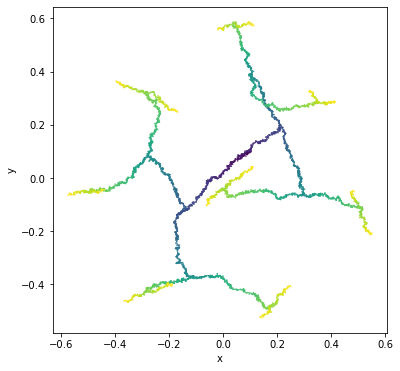

In [9]:
plt.figure(figsize=(6,6))

plot_2d_colorful(hist_map, plt.gca())

In [10]:
def make_triplot(hist_map, filename=None, colorful=False):
    
    fig, axes = plt.subplots(2,2, figsize=(8,8))
    
    if colorful:
        plot_time_vs_axis_colorful(hist_map, 0, ax=axes[0,0])
        plot_time_vs_axis_colorful(hist_map, 1, ax=axes[1,1])
        plot_2d_colorful(hist_map, ax=axes[1,0])
        axes[0,1].axis("off")
    else:
        plot_time_vs_axis_fast(hist_map, 0, ax=axes[0,0])
        plot_time_vs_axis_fast(hist_map, 1, ax=axes[1,1])
        plot_2d(hist_map, ax=axes[1,0])
        axes[0,1].axis("off")
    
    
    if filename:
        plt.savefig(filename)
        plt.clf()
        plt.close()

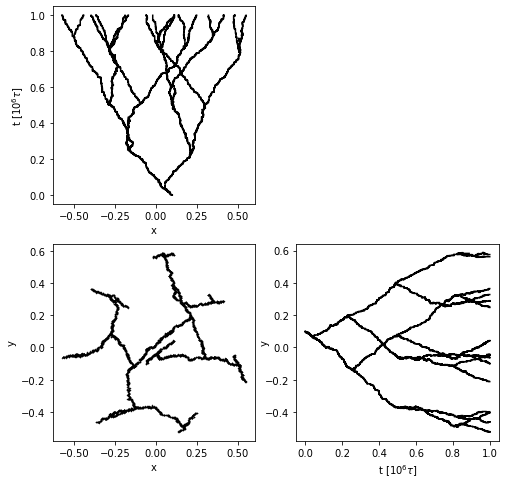

In [11]:
make_triplot(hist_map)

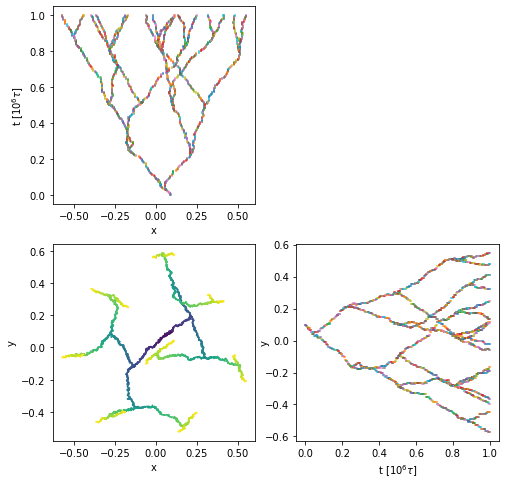

In [12]:
make_triplot(hist_map, colorful=True)

## Bulk processing data

In [44]:
def process_file(file_name, output_name):
    try:
        print("Processing file '%s'" % file_name)
        
        hist_map = read_history_map(file_name)
        make_triplot(hist_map, output_name + ".png")
        
    except Exception as e:
        print("Failed to process file '%s'" % file_name)
        print(e)

def get_root_prefix(root_folder, data_folder):
    relpath = path.relpath(root_folder, data_folder)
    
    if relpath == ".":
        relpath = ""
    else:
        relpath = relpath.replace("\\", "__").replace("/", "__") + "__"
    
    return relpath

def process_folder(data_folder = "data", figure_folder="figures"):
    try:
        mkdir(figure_folder)
        print("Created figure folder")
    except:
        pass
    
    for root, dirs, files in walk(data_folder):
       
        root_prefix = get_root_prefix(root, data_folder)
        
        file_names   = [path.join(root, file)                        for file in files]
        output_names = [path.join(figure_folder, root_prefix + file) for file in files]
        
        p = Pool(8)
        p.starmap(process_file, zip(file_names, output_names))

In [45]:
process_folder()

Processing file 'data/sigma_1.0_9'
Processing file 'data/sigma_1.0_2'
Processing file 'data/eps_0025_31'
Processing file 'data/sigma_0.5_15'
Processing file 'data/eps_005_27'
Processing file 'data/sigma_0.7_15'
Processing file 'data/eps_005_17'
Processing file 'data/sigma_1.0_5'
Processing file 'data/eps_0025_28'
Processing file 'data/eps_005_12'
Processing file 'data/eps_005_20'
Processing file 'data/sigma_1.0_10'
Processing file 'data/sigma_0.2_10'
Processing file 'data/eps_0025_17'
Processing file 'data/sigma_1.0_13'
Processing file 'data/eps_0025_2'
Processing file 'data/sigma_1.0_12'
Processing file 'data/sigma_0.2_5'
Processing file 'data/sigma_1.0_0'
Processing file 'data/eps_005_18'
Processing file 'data/sigma_0.7_2'
Processing file 'data/eps_0025_3'
Processing file 'data/long_7'
Processing file 'data/eps_0025_4'
Processing file 'data/sigma_1.0_4'
Processing file 'data/sigma_0.5_6'
Processing file 'data/sigma_0.2_6'
Processing file 'data/eps_005_1'
Processing file 'data/sigma_0